In [1]:
!pip install pyspark==3.5.0 delta-spark==3.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425346 sha256=5e63cdb98b5182e9e0a980ea7ea534987a919dc71090824a7c990d3200abf165
  Stored in directory: /root/.cache/pip/wheels/38/df/61/8c121f50c3cffd77f8178180dd232d90b3b99d1bd61fb6d6be
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.1
    Uninstalling pyspark-3.5.1:
      Successfully uninstalled pyspark-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires pyspark[connect]~=3.5.1, but you have pyspark 3.5.0 which is incompatible.


In [76]:
from pyspark.sql import SparkSession, functions as F, types as T
from delta import configure_spark_with_delta_pip
from datetime import datetime

# Spark with Delta enabled
builder = (
    SparkSession.builder.appName("DeltaRideHailing")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)
spark = configure_spark_with_delta_pip(builder).getOrCreate()

# Schemas
trip_schema = T.StructType([
    T.StructField("trip_id", T.IntegerType()),
    T.StructField("rider_id", T.StringType()),
    T.StructField("driver_id", T.StringType()),
    T.StructField("city", T.StringType()),
    T.StructField("distance_km", T.DoubleType()),
    T.StructField("fare", T.DoubleType()),
    T.StructField("tip", T.DoubleType()),
    T.StructField("ts", T.TimestampType())
])

driver_schema = T.StructType([
    T.StructField("driver_id", T.StringType()),
    T.StructField("driver_name", T.StringType()),
    T.StructField("rating", T.DoubleType()),
    T.StructField("vehicle", T.StringType())
])

# Rows using Python datetime
trips_rows = [
    (1001, "R001", "D010", "Bengaluru", 12.4, 320.0, 20.0, datetime(2025,8,8,8,5)),
    (1002, "R002", "D011", "Hyderabad", 6.2, 150.0, 10.0, datetime(2025,8,8,8,15)),
    (1003, "R003", "D012", "Pune", 3.5, 90.0, 0.0, datetime(2025,8,8,8,20)),
    (1004, "R001", "D010", "Bengaluru", 18.9, 480.0, 25.0, datetime(2025,8,8,8,45)),
    (1005, "R004", "D013", "Chennai", 10.0, 260.0, 15.0, datetime(2025,8,8,9,5)),
    (1006, "R005", "D012", "Pune", 2.2, 70.0, 0.0, datetime(2025,8,8,9,10)),
]

drivers_rows = [
    ("D010","Anil", 4.8,"WagonR"),
    ("D011","Sana", 4.6,"i20"),
    ("D012","Rakesh", 4.4,"Swift"),
    ("D013","Meera", 4.9,"Ciaz")
]

# Create DataFrames
trips_df = spark.createDataFrame(trips_rows, schema=trip_schema)
drivers_df = spark.createDataFrame(drivers_rows, schema=driver_schema)

# Save as Delta
BASE = "/tmp/delta/ride_hailing"
TRIPS_PATH = f"{BASE}/trips"
DRIVERS_PATH = f"{BASE}/drivers"
trips_df.write.format("delta").mode("overwrite").save(TRIPS_PATH)
drivers_df.write.format("delta").mode("overwrite").save(DRIVERS_PATH)

print("Seeded:")
print(" Trips ->", TRIPS_PATH)
print(" Drivers ->", DRIVERS_PATH)


Seeded:
 Trips -> /tmp/delta/ride_hailing/trips
 Drivers -> /tmp/delta/ride_hailing/drivers


1. Managed vs Unmanaged Tables


In [5]:
# Create a managed Delta table trips_managed by AS SELECT from the Delta path

spark.sql(f"create table trips_managed using delta as select * from delta.`{TRIPS_PATH}`")



DataFrame[]

In [10]:
spark.sql("select * from trips_managed").show()

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|
|   1002|    R002|     D011|Hyderabad|        6.2|150.0|10.0|2025-08-08 08:15:00|
|   1003|    R003|     D012|     Pune|        3.5| 90.0| 0.0|2025-08-08 08:20:00|
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|25.0|2025-08-08 08:45:00|
|   1005|    R004|     D013|  Chennai|       10.0|260.0|15.0|2025-08-08 09:05:00|
|   1006|    R005|     D012|     Pune|        2.2| 70.0| 0.0|2025-08-08 09:10:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



In [11]:
# Create an external (unmanaged) table drivers_ext that points to DRIVERS_PATH

spark.sql(f"create table drivers_ext using delta location '{DRIVERS_PATH}'")

DataFrame[]

In [12]:
spark.sql("select * from drivers_ext").show()

+---------+-----------+------+-------+
|driver_id|driver_name|rating|vehicle|
+---------+-----------+------+-------+
|     D012|     Rakesh|   4.4|  Swift|
|     D013|      Meera|   4.9|   Ciaz|
|     D010|       Anil|   4.8| WagonR|
|     D011|       Sana|   4.6|    i20|
+---------+-----------+------+-------+



In [13]:
# Verify locations with DESCRIBE DETAIL and explain the difference in your own words

spark.sql("DESCRIBE DETAIL trips_managed").show()

+------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+----------------+--------+-----------+----------+----------------+----------------+--------------------+
|format|                  id|                name|description|            location|           createdAt|        lastModified|partitionColumns|numFiles|sizeInBytes|properties|minReaderVersion|minWriterVersion|       tableFeatures|
+------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+----------------+--------+-----------+----------+----------------+----------------+--------------------+
| delta|2c489e49-44f1-4d2...|spark_catalog.def...|       NULL|file:/content/spa...|2025-08-14 09:46:...|2025-08-14 09:46:...|              []|       2|       4536|        {}|               1|               2|[appendOnly, inva...|
+------+--------------------+--------------------+-----------+------------------

In [14]:
spark.sql("DESCRIBE DETAIL trips_managed").show()

+------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+----------------+--------+-----------+----------+----------------+----------------+--------------------+
|format|                  id|                name|description|            location|           createdAt|        lastModified|partitionColumns|numFiles|sizeInBytes|properties|minReaderVersion|minWriterVersion|       tableFeatures|
+------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+----------------+--------+-----------+----------+----------------+----------------+--------------------+
| delta|2c489e49-44f1-4d2...|spark_catalog.def...|       NULL|file:/content/spa...|2025-08-14 09:46:...|2025-08-14 09:46:...|              []|       2|       4536|        {}|               1|               2|[appendOnly, inva...|
+------+--------------------+--------------------+-----------+------------------

Imp :- DESCRIBE DETAIL is used obtain metadata of a delta table.

2. Read & Explore

In [15]:
# Read both tables, print schemas, and show 10 rows

#spark.table() is used to retrivev registered table
trips = spark.table("trips_managed")

trips.printSchema()

trips.show(10)

root
 |-- trip_id: integer (nullable = true)
 |-- rider_id: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- city: string (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- fare: double (nullable = true)
 |-- tip: double (nullable = true)
 |-- ts: timestamp (nullable = true)

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|
|   1002|    R002|     D011|Hyderabad|        6.2|150.0|10.0|2025-08-08 08:15:00|
|   1003|    R003|     D012|     Pune|        3.5| 90.0| 0.0|2025-08-08 08:20:00|
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|25.0|2025-08-08 08:45:00|
|   1005|    R004|     D013|  Chennai|       10.0|260.0|15.0|2025-08-08 09:05:00|
|   1006|    R005|     D012|  

In [18]:
drivers = spark.table("drivers_ext")

drivers.printSchema()

drivers.show(10)

root
 |-- driver_id: string (nullable = true)
 |-- driver_name: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- vehicle: string (nullable = true)

+---------+-----------+------+-------+
|driver_id|driver_name|rating|vehicle|
+---------+-----------+------+-------+
|     D012|     Rakesh|   4.4|  Swift|
|     D013|      Meera|   4.9|   Ciaz|
|     D010|       Anil|   4.8| WagonR|
|     D011|       Sana|   4.6|    i20|
+---------+-----------+------+-------+



In [17]:
# Compute a derived column total_amount = fare + tip and show top 5 trips by total_amount

trips = trips.withColumn("total_amount", F.col("fare") + F.col("tip"))
trips.orderBy(F.col("total_amount").desc()).show(5)

+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|total_amount|
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|25.0|2025-08-08 08:45:00|       505.0|
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|       340.0|
|   1005|    R004|     D013|  Chennai|       10.0|260.0|15.0|2025-08-08 09:05:00|       275.0|
|   1002|    R002|     D011|Hyderabad|        6.2|150.0|10.0|2025-08-08 08:15:00|       160.0|
|   1003|    R003|     D012|     Pune|        3.5| 90.0| 0.0|2025-08-08 08:20:00|        90.0|
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
only showing top 5 rows



3. Update (Business Rule)

In [21]:
# Increase tip by 5 for trips in Bengaluru where distance_km > 15

trips = trips.withColumn("tip" ,
                       F.when((F.col("city") == "Bengaluru") & (F.col("distance_km") > 15), F.col("tip") + 5)
                       .otherwise(F.col("tip"))
                       )


In [22]:
# Show before/after for affected rows only
before = trips.filter((F.col("city") == "Bengaluru") & (F.col("distance_km") > 15))
before.show()

after = trips.filter((F.col("city") == "Bengaluru") & (F.col("distance_km") > 15))
after.show()

+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|total_amount|
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|35.0|2025-08-08 08:45:00|       505.0|
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+

+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|total_amount|
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|35.0|2025-08-08 08:45:00|       505.0|
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+



4. Delete (Data Quality)

In [29]:
# Delete trips where fare <= 0 or distance_km <= 0 (simulate bad ingest)
# Show remaining row count
from delta.tables import DeltaTable
from pyspark.sql import functions as F

delta_trips = DeltaTable.forName(spark, "trips_managed")
print("Before deletion:", delta_trips.toDF().count())

delta_trips.delete(condition=(F.col("fare") <=0) | (F.col("distance_km") <=0))

print("After deletion:", delta_trips.toDF().count())
delta_trips.toDF().show()


Before deletion: 6
After deletion: 6
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|
|   1002|    R002|     D011|Hyderabad|        6.2|150.0|10.0|2025-08-08 08:15:00|
|   1003|    R003|     D012|     Pune|        3.5| 90.0| 0.0|2025-08-08 08:20:00|
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|25.0|2025-08-08 08:45:00|
|   1005|    R004|     D013|  Chennai|       10.0|260.0|15.0|2025-08-08 09:05:00|
|   1006|    R005|     D012|     Pune|        2.2| 70.0| 0.0|2025-08-08 09:10:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



5. Merge (Upsert New Batch)


In [32]:
## Create a new inline batch with:
# one existing trip_id (e.g., 1004) but a corrected fare or tip, and
# one new trip (e.g., 1007). Perform a MERGE (match on trip_id ) to update the existing and insert the new.
# Show rows for trip_id IN (1004,1007) to confirm

from pyspark.sql import Row

new_data = [
    (1004, "R001", "D010", "Bengaluru", 18.9, 500.0, 30.0, "2025-08-08 08:45:00"),
    (1007, "R006", "D013", "Mumbai", 7.5, 200.0, 20.0, "2025-08-13 10:00:00")
]
columns = ["trip_id", "rider_id", "driver_id", "city", "distance_km", "fare", "tip", "ts"]

new_df = spark.createDataFrame(new_data, schema=columns)
new_df = new_df.withColumn("ts", F.col("ts").cast("timestamp"))

delta_trips.alias("tgt").merge( source= new_df.alias("src"),
                               condition = "tgt.trip_id = src.trip_id").whenMatchedUpdateAll().whenNotMatchedInsertAll().execute()

spark.sql("select * from trips_managed where trip_id in (1004,1007)").show()

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|500.0|30.0|2025-08-08 08:45:00|
|   1007|    R006|     D013|   Mumbai|        7.5|200.0|20.0|2025-08-13 10:00:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



6. Gold View (Join & KPIs)

In [34]:
# Join trips with drivers on driver_id

delta_trips = DeltaTable.forName(spark, "trips_managed")
delta_drivers = DeltaTable.forName(spark, "drivers_ext")

df_trips = delta_trips.toDF()
df_drivers = delta_drivers.toDF()

df_gold = (df_trips.join(df_drivers, "driver_id").withColumn("total_amount", F.col("fare") + F.col("tip"))
          .select("trip_id", "city", "driver_name", "rating", "distance_km", "total_amount", "ts"))

df_gold.show()

+-------+---------+-----------+------+-----------+------------+-------------------+
|trip_id|     city|driver_name|rating|distance_km|total_amount|                 ts|
+-------+---------+-----------+------+-----------+------------+-------------------+
|   1004|Bengaluru|       Anil|   4.8|       18.9|       530.0|2025-08-08 08:45:00|
|   1005|  Chennai|      Meera|   4.9|       10.0|       275.0|2025-08-08 09:05:00|
|   1006|     Pune|     Rakesh|   4.4|        2.2|        70.0|2025-08-08 09:10:00|
|   1007|   Mumbai|      Meera|   4.9|        7.5|       220.0|2025-08-13 10:00:00|
|   1001|Bengaluru|       Anil|   4.8|       12.4|       340.0|2025-08-08 08:05:00|
|   1002|Hyderabad|       Sana|   4.6|        6.2|       160.0|2025-08-08 08:15:00|
|   1003|     Pune|     Rakesh|   4.4|        3.5|        90.0|2025-08-08 08:20:00|
+-------+---------+-----------+------+-----------+------------+-------------------+



In [35]:
# Create gold view

df_gold.createOrReplaceTempView("gold_view")

# Compute city-wise total revenue and average driver rating
city_kpi = df_gold.groupBy("city").agg(F.sum("total_amount").alias("total_revenue"),F.avg("rating").alias("avg_driver_rating"))
city_kpi.show()

+---------+-------------+-----------------+
|     city|total_revenue|avg_driver_rating|
+---------+-------------+-----------------+
|  Chennai|        275.0|              4.9|
|   Mumbai|        220.0|              4.9|
|     Pune|        160.0|              4.4|
|Bengaluru|        870.0|              4.8|
|Hyderabad|        160.0|              4.6|
+---------+-------------+-----------------+



In [36]:
# Compute driver-wise total trips and top 3 drivers by revenue

driver_kpi = df_gold.groupBy("driver_name").agg(F.count("trip_id").alias("total_trips"), F.sum("total_amount").alias("total_revenue"))
driver_kpi.orderBy(F.desc("total_revenue")).show(3)

+-----------+-----------+-------------+
|driver_name|total_trips|total_revenue|
+-----------+-----------+-------------+
|       Anil|          2|        870.0|
|      Meera|          2|        495.0|
|     Rakesh|          2|        160.0|
+-----------+-----------+-------------+
only showing top 3 rows



7. Time Travel & History

In [38]:
# Show DESCRIBE HISTORY for the trips table (the one you updated/merged)

spark.sql("DESCRIBE HISTORY trips_managed").show()

+-------+--------------------+------+--------+--------------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version|           timestamp|userId|userName|           operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend|    operationMetrics|userMetadata|          engineInfo|
+-------+--------------------+------+--------+--------------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|      1|2025-08-14 11:35:...|  NULL|    NULL|               MERGE|{predicate -> ["(...|NULL|    NULL|     NULL|          0|  Serializable|        false|{numTargetRowsCop...|        NULL|Apache-Spark/3.5....|
|      0|2025-08-14 09:46:...|  NULL|    NULL|CREATE TABLE AS S...|{isManaged -> tru...|NULL|    NULL|     NULL|       NULL|  Serializable|         true|{numFiles -

In [39]:
# Read the table as of version 0, and compare counts and a few rows with the latest version

delta_latest = delta_trips.toDF()

df_v0 = spark.read.format("delta").option("versionAsOf", 0).table("trips_managed")

print("Count of latest version:", delta_latest.count())
print("Count of version 0:", df_v0.count())


Count of latest version: 7
Count of version 0: 6


8. Partitioned Rewrite (Performance)

In [40]:
# Rewrite the trips table partitioned by city into a new Delta path
BASE_PATH = "/tmp/delta/ride_hailing"
PARTITIONED_PATH = f"{BASE_PATH}/trips_partitioned"

delta_trips = DeltaTable.forName(spark, "trips_managed")
df_trips = delta_trips.toDF()

df_trips.write.format("delta") \
    .mode("overwrite") \
    .partitionBy("city") \
    .save(PARTITIONED_PATH)



In [42]:
# Compare file layout (optional: list files) and run a simple filter city='Bengaluru' to observe read behavior/time
import os
import time

BASE_PATH = "/tmp/delta/ride_hailing/trips"
print("Non-partitioned table files:")
for root, dirs, files in os.walk(BASE_PATH):
    print(root, files)

PARTITIONED_PATH = "/tmp/delta/ride_hailing/trips_partitioned"
print("Partitioned table files:")
for root, dirs, files in os.walk(PARTITIONED_PATH):
    print(root, files)

df_nonpart = spark.read.format("delta").load(BASE_PATH)

start = time.time()
df_nonpart.filter(F.col("city") == "Bengaluru").show()
end = time.time()
print("Non-partitioned read time:", end - start, "seconds")

df_part = spark.read.format("delta").load(PARTITIONED_PATH)

start = time.time()
df_part.filter(F.col("city") == "Bengaluru").show()
end = time.time()
print("Partitioned read time:", end - start, "seconds")



Non-partitioned table files:
/tmp/delta/ride_hailing/trips ['.part-00000-4b89a2c8-cbcc-4180-98a7-cc9c812340c6-c000.snappy.parquet.crc', '.part-00001-0ac4b393-698b-43ac-b49f-6eed03344d67-c000.snappy.parquet.crc', 'part-00000-4b89a2c8-cbcc-4180-98a7-cc9c812340c6-c000.snappy.parquet', 'part-00001-0ac4b393-698b-43ac-b49f-6eed03344d67-c000.snappy.parquet']
/tmp/delta/ride_hailing/trips/_delta_log ['.00000000000000000000.json.crc', '00000000000000000000.json']
Partitioned table files:
/tmp/delta/ride_hailing/trips_partitioned []
/tmp/delta/ride_hailing/trips_partitioned/_delta_log ['.00000000000000000000.json.crc', '00000000000000000000.json']
/tmp/delta/ride_hailing/trips_partitioned/city=Chennai ['part-00000-00c2aaac-3050-4075-8d9f-5f08dd201aa7.c000.snappy.parquet', '.part-00000-00c2aaac-3050-4075-8d9f-5f08dd201aa7.c000.snappy.parquet.crc']
/tmp/delta/ride_hailing/trips_partitioned/city=Mumbai ['.part-00000-c33a76d5-14e2-4ffd-aaab-9b68f58b6ce5.c000.snappy.parquet.crc', 'part-00000-c33a76d5

9. Incremental Load Simulation

In [46]:
#
from pyspark.sql.types import IntegerType, DoubleType, TimestampType

incremental_data = [
    (1008, "R007", "D010", "Mumbai", 12.0, 300.0, 15.0, "2025-08-14 12:00:00"),
    (1009, "R008", "D011", "Mumbai", 8.5, 200.0, 10.0, "2025-08-14 12:30:00")
]

columns = ["trip_id", "rider_id", "driver_id", "city", "distance_km", "fare", "tip", "ts"]

incremental_df = spark.createDataFrame(incremental_data, columns) \
                      .withColumn("ts", F.col("ts").cast("timestamp"))

incremental_df = incremental_df.select(
    F.col("trip_id").cast(IntegerType()),
    F.col("rider_id"),
    F.col("driver_id"),
    F.col("city"),
    F.col("distance_km").cast(DoubleType()),
    F.col("fare").cast(DoubleType()),
    F.col("tip").cast(DoubleType()),
    F.col("ts").cast(TimestampType())
)

delta_trips = DeltaTable.forName(spark, "trips_managed")

incremental_df.write.format("delta").mode("append").saveAsTable("trips_managed")

df_trips = delta_trips.toDF()
df_trips.withColumn("total_amount", F.col("fare") + F.col("tip")) \
        .groupBy("city") \
        .agg(
            F.sum("total_amount").alias("city_total_revenue"),
            F.avg("fare").alias("city_avg_fare")
        ).show()

+---------+------------------+------------------+
|     city|city_total_revenue|     city_avg_fare|
+---------+------------------+------------------+
|  Chennai|             275.0|             260.0|
|   Mumbai|             745.0|233.33333333333334|
|     Pune|             160.0|              80.0|
|Bengaluru|             870.0|             410.0|
|Hyderabad|             160.0|             150.0|
+---------+------------------+------------------+



10. Simple Streaming (File Streaming - Console)

In [48]:
# Start a structured stream that reads Delta from TRIPS_PATH in readStream mode and writes to console (append)

df_stream = spark.readStream.format("delta").load(TRIPS_PATH)
query = (df_stream.writeStream.format("console").outputMode("append").trigger(processingTime='5 seconds').start())
time.sleep(5)

In [54]:
# While the stream runs, append another tiny batch (e.g., one more Mumbai trip) and observe the new row displayed
from pyspark.sql import functions as F
from pyspark.sql import types as T
import time

new_trip = [
    (1010, "R007", "D014", "Mumbai", 8.0, 220.0, 15.0, "2025-08-14 11:00:00")
]
columns = ["trip_id", "rider_id", "driver_id", "city", "distance_km", "fare", "tip", "ts"]
new_df = spark.createDataFrame(new_trip, columns)
new_df = new_df.withColumn("ts", F.col("ts").cast("timestamp"))
new_df = new_df.withColumn("trip_id", F.col("trip_id").cast(T.IntegerType()))
# Append to the Delta table path
new_df.write.format("delta").mode("append").save(TRIPS_PATH)

time.sleep(10)

query.stop()


10. Visualization

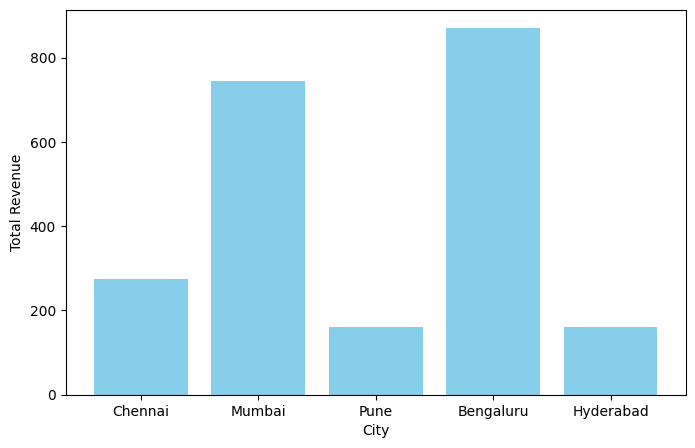

In [56]:
# Convert the gold view results (city revenue) to Pandas and plot a bar chart of city vs total revenue
import matplotlib.pyplot as plt

city_kpi_df =city_kpi.toPandas()

plt.figure(figsize=(8,5))
plt.bar(city_kpi_df['city'], city_kpi_df['total_revenue'], color='skyblue')
plt.xlabel("City")
plt.ylabel("Total Revenue")
plt.show()


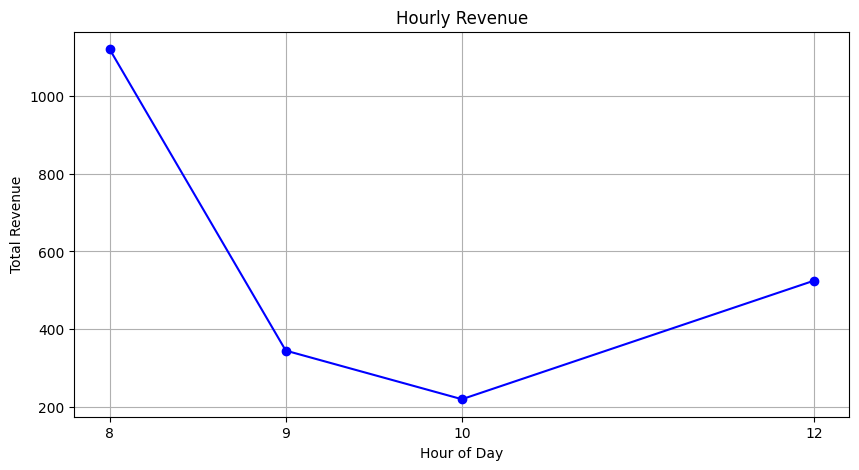

In [58]:
# Plot a line chart of hourly revenue: group by hour(ts) and sum total_amount
from pyspark.sql.functions import hour

hourly_revenue = df_gold.withColumn("hour", hour("ts")) \
                        .groupBy("hour") \
                        .agg(F.sum("total_amount").alias("hourly_revenue")) \
                        .orderBy("hour")

hourly_revenue_pdf = hourly_revenue.toPandas()

plt.figure(figsize=(10,5))
plt.plot(hourly_revenue_pdf['hour'], hourly_revenue_pdf['hourly_revenue'], marker='o', color='blue')
plt.title("Hourly Revenue")
plt.xlabel("Hour of Day")
plt.ylabel("Total Revenue")
plt.xticks(hourly_revenue_pdf['hour'])
plt.grid(True)
plt.show()

12. Managed vs Unmanaged Cleanup

In [59]:
# DROP TABLE the managed and unmanaged tables; verify:

spark.sql("drop table trips_managed")
spark.sql("drop table drivers_ext")


DataFrame[]

In [60]:
spark.sql("show tables").show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|         |gold_view|      false|
+---------+---------+-----------+



In [62]:
!ls /tmp/delta/ride_hailing/drivers

_delta_log
part-00000-c6234e8f-d0fd-4bef-b344-ca2acda9db3a-c000.snappy.parquet
part-00001-9db13439-b007-4acb-a427-8dc252ae61a8-c000.snappy.parquet


In [63]:
spark.sql("DESCRIBE DETAIL trips_managed").show()


AnalysisException: [TABLE_OR_VIEW_NOT_FOUND] The table or view `trips_managed` cannot be found. Verify the spelling and correctness of the schema and catalog.
If you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.
To tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABLE IF EXISTS.; line 1 pos 0;
'DescribeDeltaDetailCommand
+- 'UnresolvedTable [trips_managed], DESCRIBE DETAIL


13. Constraint/Quality check (optional)

In [65]:
from pyspark.sql import functions as F
from pyspark.sql import types as T

bad_data = [
    (1011, "R008", "D015", "Delhi", 5.0, 150.0, -5.0, "2025-08-14 12:00:00"),  # tip < 0
    (1012, "R009", "D016", "Kolkata", 7.0, 200.0, 10.0, "2025-08-14 12:30:00") # valid row
]

columns = ["trip_id", "rider_id", "driver_id", "city", "distance_km", "fare", "tip", "ts"]

new_df = spark.createDataFrame(bad_data, columns)
new_df = new_df.withColumn("ts", F.col("ts").cast("timestamp"))
new_df = new_df.withColumn("trip_id", F.col("trip_id").cast(T.IntegerType()))
clean_df = new_df.filter(F.col("tip") >= 0)

clean_df.write.format("delta").mode("append").save(TRIPS_PATH)

spark.read.format("delta").load(TRIPS_PATH).filter(F.col("trip_id").isin(1011, 1012)).show()


+-------+--------+---------+-------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|   city|distance_km| fare| tip|                 ts|
+-------+--------+---------+-------+-----------+-----+----+-------------------+
|   1012|    R009|     D016|Kolkata|        7.0|200.0|10.0|2025-08-14 12:30:00|
+-------+--------+---------+-------+-----------+-----+----+-------------------+



14. Convert Parquet - Delta (Optional)

In [69]:
# Save a small subset of trips as Parquet in a new folder and CONVERT TO DELTA

data = [(1001,"R001","D010","Bengaluru",12.4,320.0,20.0,"2025-08-08 08:05:00"),
        (1002,"R002","D011","Hyderabad",6.2,150.0,10.0,"2025-08-08 08:15:00"),
        (1003,"R003","D012","Pune",3.5,90.0,0.0,"2025-08-08 08:20:00")]

columns = ["trip_id","rider_id","driver_id","city","distance_km","fare","tip","ts"]

df = spark.createDataFrame(data, columns)
df = df.withColumn("ts", F.col("ts").cast("timestamp"))

PARQUET_PATH = "/tmp/trips_parquet"
df.write.format("parquet").mode("overwrite").save(PARQUET_PATH)
print("Saved as Parquet at:", PARQUET_PATH)

DeltaTable.convertToDelta(spark, f"parquet.`{PARQUET_PATH}`")
delta_table = DeltaTable.forPath(spark, PARQUET_PATH)
delta_table.toDF().show()

Saved as Parquet at: /tmp/trips_parquet
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|
|   1002|    R002|     D011|Hyderabad|        6.2|150.0|10.0|2025-08-08 08:15:00|
|   1003|    R003|     D012|     Pune|        3.5| 90.0| 0.0|2025-08-08 08:20:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



In [70]:
# Show it can now accept MERGE and time travel
new_data = [
    (102, "R002", "D002", "Mumbai", 5.2, 150.0, 12.0, "2025-08-14 09:00:00"),
    (104, "R004", "D004", "Chennai", 8.0, 220.0, 18.0, "2025-08-14 11:00:00")
]
new_df = spark.createDataFrame(new_data, columns)
new_df = new_df.withColumn("ts", F.col("ts").cast("timestamp"))

delta_table.alias("tgt").merge(
    new_df.alias("src"),
    "tgt.trip_id = src.trip_id"
).whenMatchedUpdateAll().whenNotMatchedInsertAll().execute()

print("After MERGE:")
delta_table.toDF().show()

print("Time travel to version 0:")
df_v0 = spark.read.format("delta").option("versionAsOf", 0).load(PARQUET_PATH)
df_v0.show()

After MERGE:
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|
|    104|    R004|     D004|  Chennai|        8.0|220.0|18.0|2025-08-14 11:00:00|
|    102|    R002|     D002|   Mumbai|        5.2|150.0|12.0|2025-08-14 09:00:00|
|   1002|    R002|     D011|Hyderabad|        6.2|150.0|10.0|2025-08-08 08:15:00|
|   1003|    R003|     D012|     Pune|        3.5| 90.0| 0.0|2025-08-08 08:20:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+

Time travel to version 0:
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+--

15. Bonus KPI Dashboard

In [77]:
from delta.tables import DeltaTable

delta_trips = DeltaTable.forPath(spark, TRIPS_PATH)
delta_drivers = DeltaTable.forPath(spark, DRIVERS_PATH)

df_trips = delta_trips.toDF()
df_drivers = delta_drivers.toDF()

df_gold = (df_trips.join(df_drivers, "driver_id")
           .withColumn("total_amount", F.col("fare") + F.col("tip"))
           .select("trip_id","city","driver_name","rating","distance_km","total_amount","ts"))

df_gold.show()


+-------+---------+-----------+------+-----------+------------+-------------------+
|trip_id|     city|driver_name|rating|distance_km|total_amount|                 ts|
+-------+---------+-----------+------+-----------+------------+-------------------+
|   1001|Bengaluru|       Anil|   4.8|       12.4|       340.0|2025-08-08 08:05:00|
|   1002|Hyderabad|       Sana|   4.6|        6.2|       160.0|2025-08-08 08:15:00|
|   1003|     Pune|     Rakesh|   4.4|        3.5|        90.0|2025-08-08 08:20:00|
|   1004|Bengaluru|       Anil|   4.8|       18.9|       505.0|2025-08-08 08:45:00|
|   1005|  Chennai|      Meera|   4.9|       10.0|       275.0|2025-08-08 09:05:00|
|   1006|     Pune|     Rakesh|   4.4|        2.2|        70.0|2025-08-08 09:10:00|
+-------+---------+-----------+------+-----------+------------+-------------------+



In [78]:
# Total revenue
pdf = df_gold.toPandas()

total_revenue = pdf['total_amount'].sum()
print("Total Revenue:", total_revenue)



Total Revenue: 1440.0


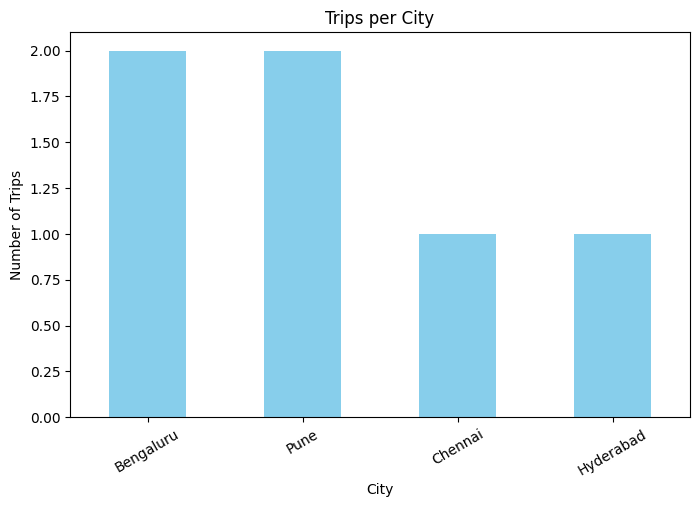

In [79]:
# Trips per city (bar)

city_counts = pdf.groupby('city')['trip_id'].count().sort_values(ascending=False)
plt.figure(figsize=(8,5))
city_counts.plot(kind='bar', color='skyblue')
plt.title('Trips per City')
plt.ylabel('Number of Trips')
plt.xlabel('City')
plt.xticks(rotation=30)
plt.show()

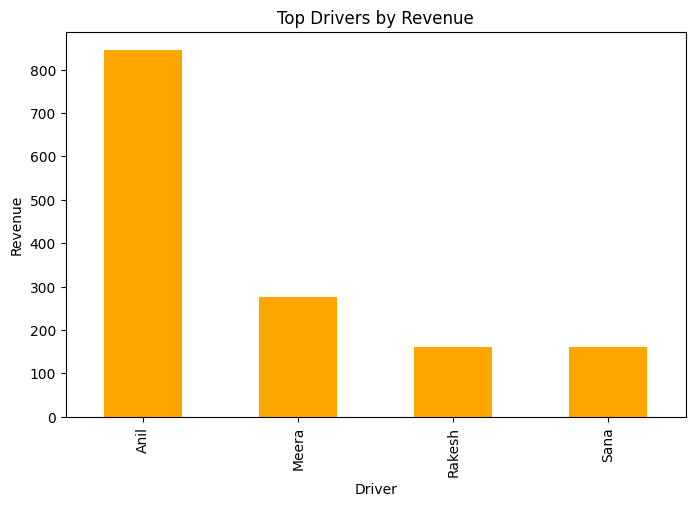

In [80]:
# Top drivers by revenue (bar)

driver_revenue = pdf.groupby('driver_name')['total_amount'].sum().sort_values(ascending=False)
plt.figure(figsize=(8,5))
driver_revenue.plot(kind='bar', color='orange')
plt.title('Top Drivers by Revenue')
plt.ylabel('Revenue')
plt.xlabel('Driver')
plt.show()

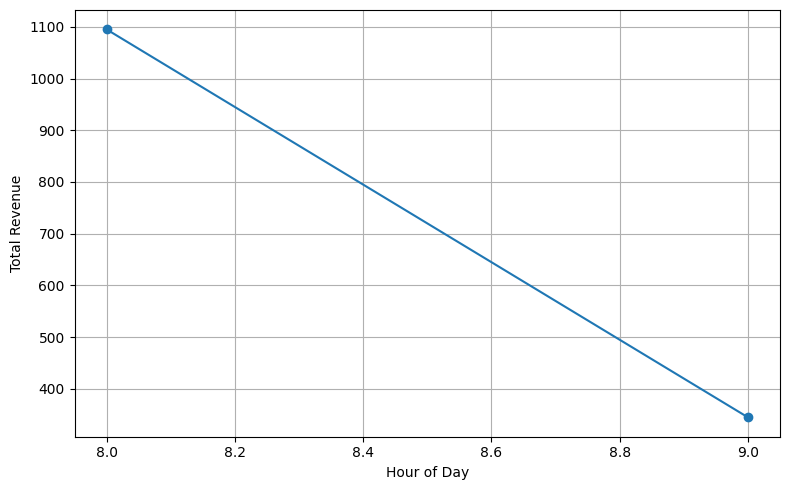

In [82]:
# Revenue by hour (line)

pdf['hour'] = pdf['ts'].dt.hour
hourly_revenue = pdf.groupby('hour')['total_amount'].sum()
plt.figure(figsize=(8,5))
hourly_revenue.plot(kind='line', marker='o')
plt.ylabel('Total Revenue')
plt.xlabel('Hour of Day')
plt.grid(True)
plt.tight_layout()
plt.show()